In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder



In [27]:
skin_df = pd.read_csv('ham10000/HAM10000_metadata.csv')

In [28]:
SIZE = 65

In [29]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

C:\Users\Chaitanya\AppData\Local\Temp\ipykernel_6908\2659561328.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


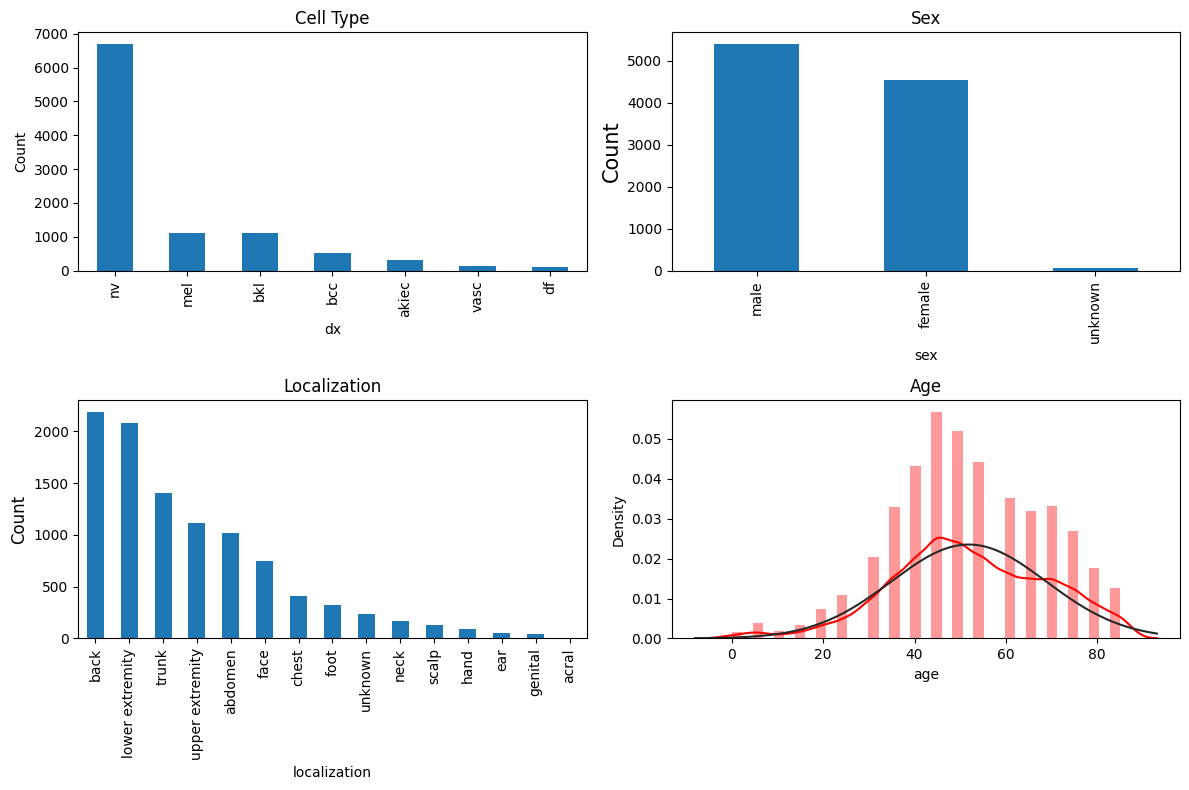

In [30]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [31]:
 
from sklearn.utils import resample
print(skin_df['label'].value_counts())



df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [32]:

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [33]:

print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [34]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('ham10000/', '*', '*.jpg'))}

In [35]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

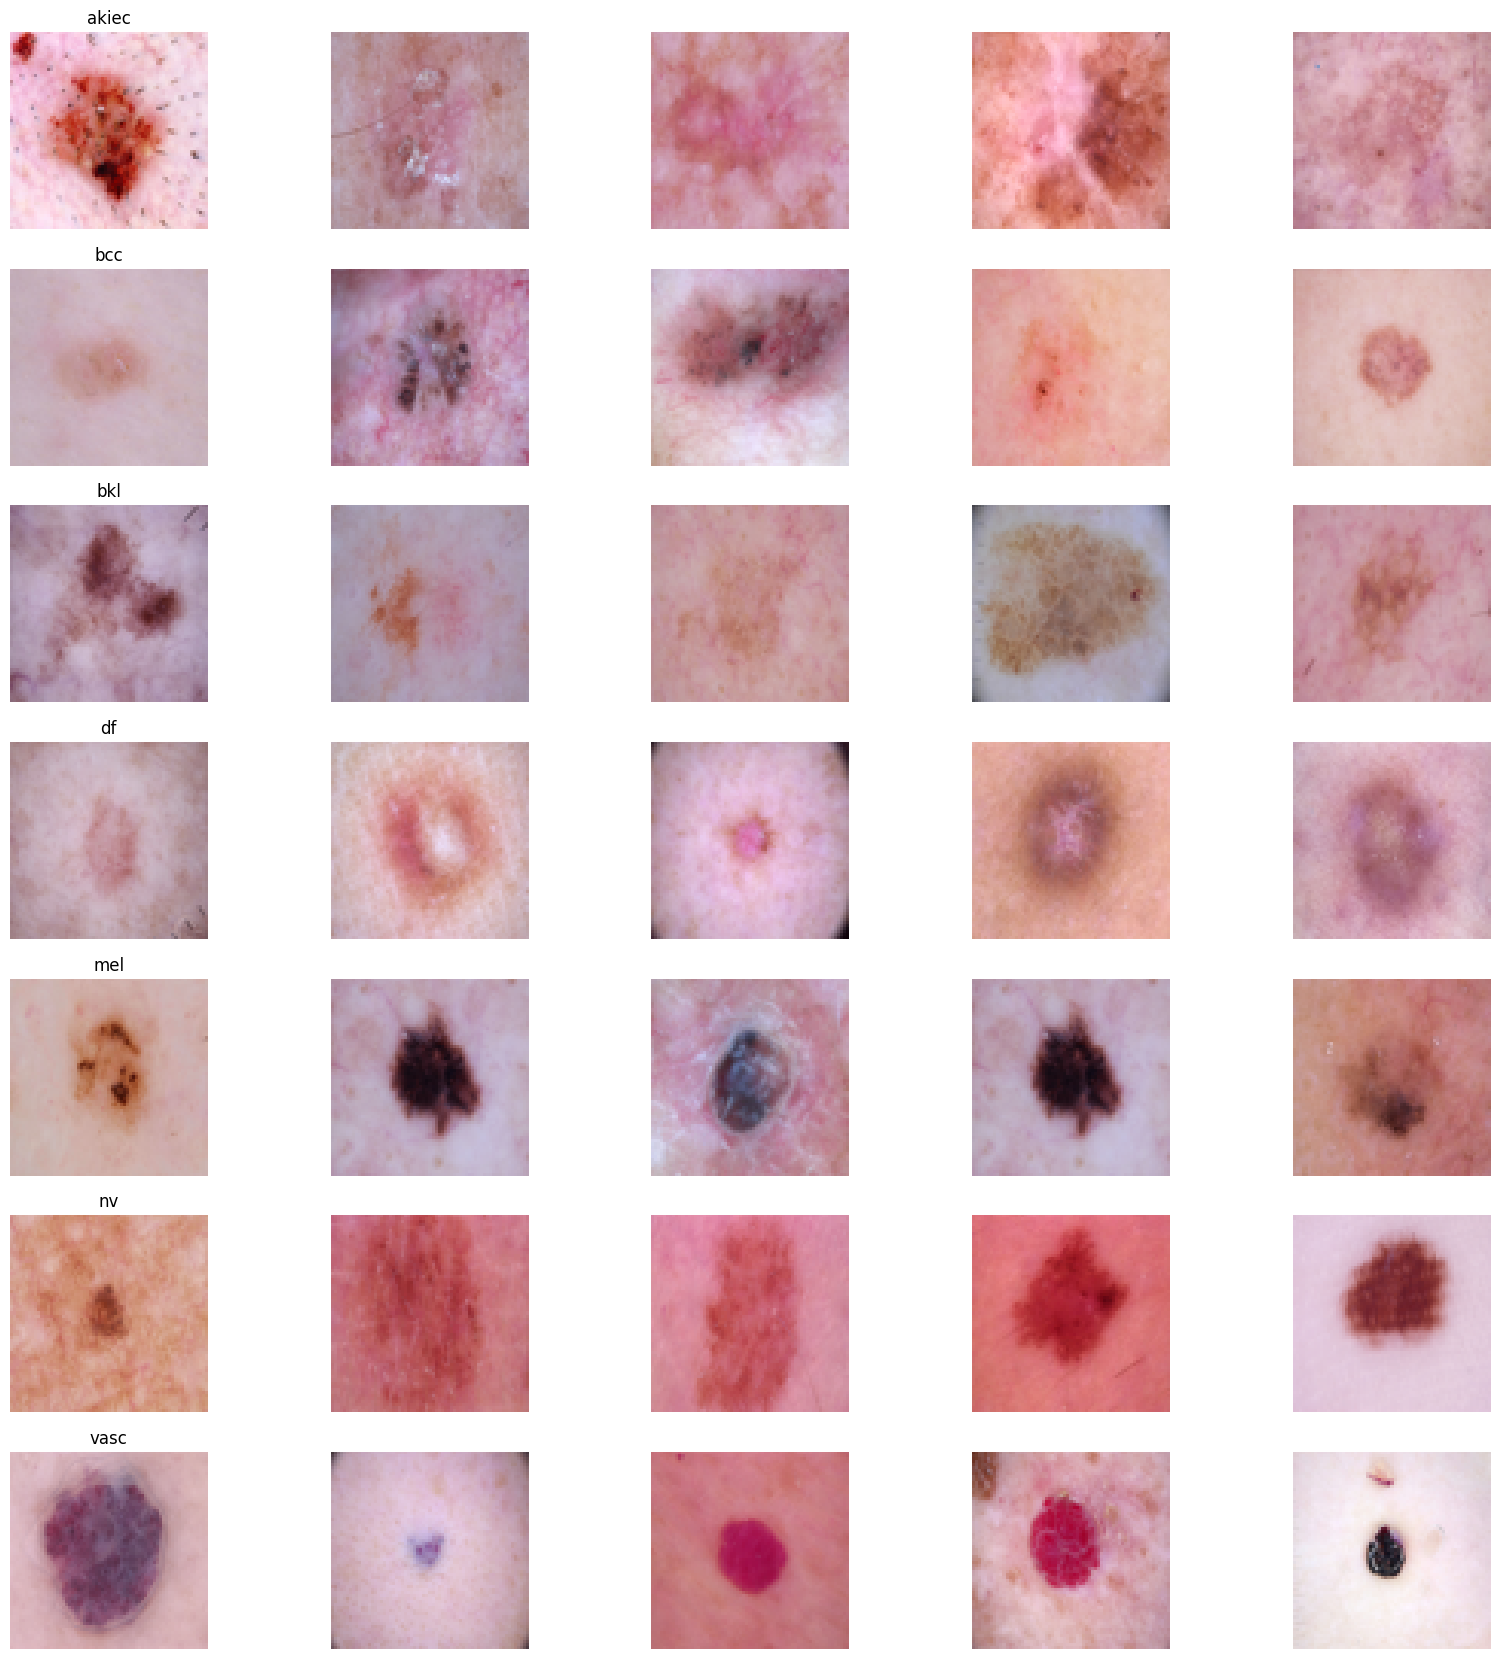

In [36]:
n_samples = 5  

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [37]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  
Y=skin_df_balanced['label']  
Y_cat = to_categorical(Y, num_classes=7) 

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [39]:
num_classes = 7

import keras_tuner as kt
import tensorflow as tf

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=256, step=32),
                     (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32),
                     (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(hp.Int('conv3_units', min_value=32, max_value=64, step=32),
                     (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'))
    model.add(Dense(7, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
    return model

ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
!pip 

In [15]:
tuner = kt.Hyperband(build_model,
                     objective='val_acc',
                     max_epochs=35,
                     factor=3,
                     directory='my_dir',
                     project_name='skin_cancer_hyperparam_tuning')

INFO:tensorflow:Reloading Tuner from my_dir\skin_cancer_hyperparam_tuning\tuner0.json


In [16]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        print("Training finished.")
        

tuner = kt.Hyperband(build_model,
                     objective='val_acc',
                     max_epochs=35,
                     factor=3,
                     directory='my_dir',
                     project_name='skin_cancer_hyperparam_tuning')

tuner.search(x_train, y_train, epochs=35, validation_data=(x_test, y_test), callbacks=[ClearTrainingOutput()])

INFO:tensorflow:Reloading Tuner from my_dir\skin_cancer_hyperparam_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hps}")

Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000015A8A8E28E0>


In [18]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, epochs=35, batch_size=16, validation_data=(x_test, y_test))

score = best_model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/35
165/165 [==============================] - 4s 22ms/step - loss: 1.9198 - acc: 0.1848 - val_loss: 1.8495 - val_acc: 0.2320
Epoch 2/35
165/165 [==============================] - 3s 20ms/step - loss: 1.7546 - acc: 0.2697 - val_loss: 1.7550 - val_acc: 0.2869
Epoch 3/35
165/165 [==============================] - 3s 19ms/step - loss: 1.6873 - acc: 0.3162 - val_loss: 1.6788 - val_acc: 0.3463
Epoch 4/35
165/165 [==============================] - 3s 20ms/step - loss: 1.5165 - acc: 0.4076 - val_loss: 1.4403 - val_acc: 0.4366
Epoch 5/35
165/165 [==============================] - 3s 20ms/step - loss: 1.3701 - acc: 0.4709 - val_loss: 1.3528 - val_acc: 0.4846
Epoch 6/35
165/165 [==============================] - 3s 20ms/step - loss: 1.3313 - acc: 0.4830 - val_loss: 1.5984 - val_acc: 0.4160
Epoch 7/35
165/165 [==============================] - 3s 20ms/step - loss: 1.2536 - acc: 0.5215 - val_loss: 1.3193 - val_acc: 0.4663
Epoch 8/35
165/165 [==============================] - 3s 20ms/step - 

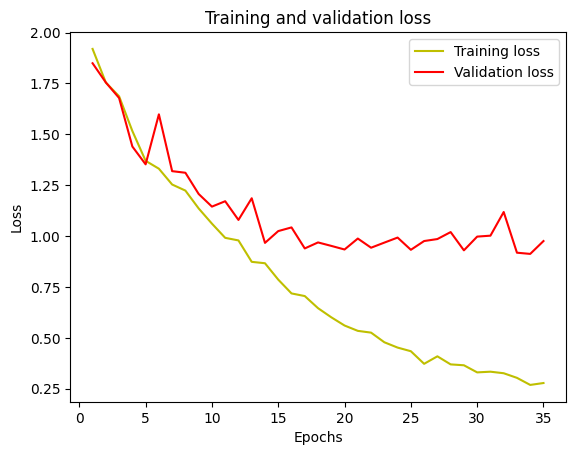

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

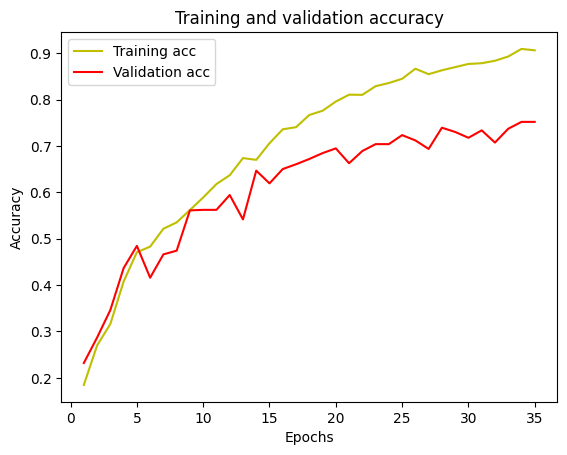

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

28/28 [==============================] - 1s 16ms/step


<Axes: >

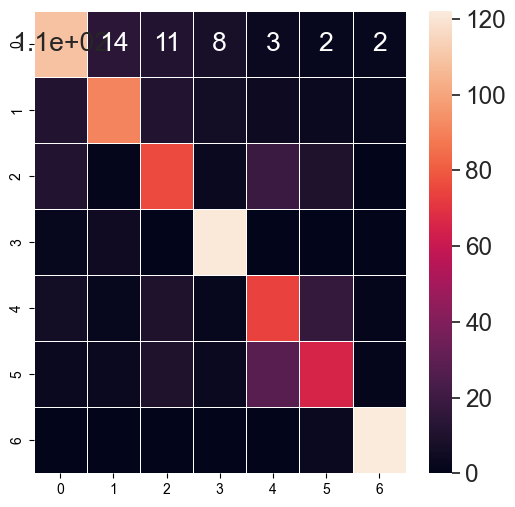

In [22]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

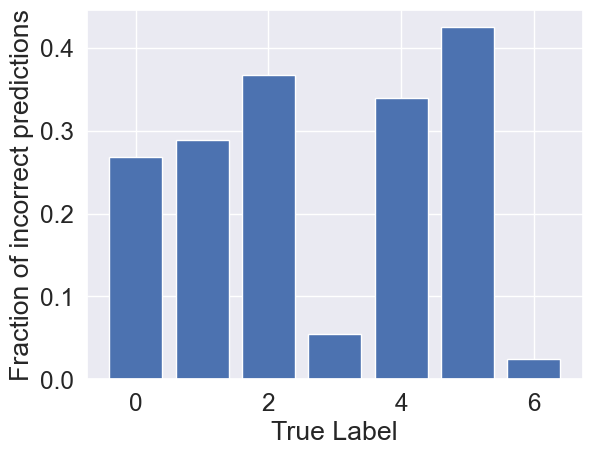

In [23]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [24]:
from tensorflow.keras.models import load_model
best_model.save('your_model.h5')


In [2]:
from tensorflow.keras.models import load_model
loaded_model = load_model('your_model.h5')

In [9]:
from PIL import Image
import numpy as np

# Load and preprocess the input image
input_image_path = 'images/act_img/act_mel/mel2.jpg'  # Replace with the path to your input image
input_image = Image.open(input_image_path)
input_image = input_image.resize((65, 65))  # Resize to 32x32 pixels
input_image = np.asarray(input_image) / 255.0  # Normalize to 0-1 scale

# Expand the dimensions to match the model's input shape
input_image = np.expand_dims(input_image, axis=0)

# Make predictions
predictions = loaded_model.predict(input_image)

# Interpret the results
predicted_class = np.argmax(predictions)  # Get the class with the highest probability
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']  # Replace with your class names
predicted_class_name = class_names[predicted_class]

print(f"The predicted class is: {predicted_class_name}")

1/1 [==============================] - 0s 31ms/step
The predicted class is: mel
